In [1]:
## Preloads
using Statistics
using FFTW
using Distributed
using Plots
using BenchmarkTools
using Profile
using LinearAlgebra
using Measures
using HDF5
using Plots
push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
using DHC_2DUtils
using MLDatasets
using Images
using HDF5
theme(:dark)

In [2]:
# read the MNIST training data, x=image, y=class
train_x, train_y = CIFAR10.traindata();
test_x, test_y   = CIFAR10.testdata();

Want to ask a few questions

1. What is the Lipschitz constant, approx?

2. What is the average magnitude of projection of a typical image onto its classification axis?

3. I should compare the above with and without ISO.

4. Try to guess how big the adversarial noise will need to be, and hopefully show it needs large norm, then do some adversarial gradient descent.

In [3]:
lst_train = Array{Any}(undef, 0)
for i = 1:size(train_x)[4]
    s = StackedView(transpose(train_x[:,:,1,i]),transpose(train_x[:,:,2,i]),transpose(train_x[:,:,3,i]));
    temp = Images.Gray.(colorview(RGB, s))
    timg = convert(Array{Float64}, temp)
    push!(lst_train,timg)
end

lst_test = Array{Any}(undef, 0)
for i = 1:size(test_x)[4]
    s = StackedView(transpose(test_x[:,:,1,i]),transpose(test_x[:,:,2,i]),transpose(test_x[:,:,3,i]));
    temp = Images.Gray.(colorview(RGB, s))
    timg = convert(Array{Float64}, temp)
    push!(lst_test,timg)
end

In [4]:
function cifar_pad(im; θ=0.0)
    imbig = imresize(im,(64,64))
    mu_imbig = mean(imbig)
    imbig .-= mu_imbig
    imbig .*= wind_2d(64)
    impad = zeros(Float64,128,128)
    impad[96:-1:33,33:96] = imbig

    if θ != 0.0
        imrot = imrotate(impad, θ, axes(impad), Cubic(Throw(OnGrid())))
        imrot[findall(imrot .!= imrot)] .= 0.0
        return imrot .+ mu_imbig
    end

    return impad.+ mu_imbig
end

function wind_2d(nx)
    dx   = nx/2-1
    filter = zeros(Float64, nx, nx)
    A = DSP.tukey(nx, 0.3)
    itp = extrapolate(interpolate(A,BSpline(Linear())),0)
    @inbounds for x = 1:nx
        sx = x-dx-1    # define sx,sy so that no fftshift() needed
        for y = 1:nx
            sy = y-dx-1
            r  = sqrt.((sx).^2 + (sy).^2) + nx/2
            filter[x,y] = itp(r)
        end
    end
    return filter
end

using DSP
using ProgressMeter
using Interpolations

In [5]:
function cifar_DHC(x)
    image    = cifar_pad(x[:,:], θ=0.0)
    WST = DHC_compute(image, filter_hash,filter_hash)
    return WST
end

cifar_DHC (generic function with 1 method)

In [6]:
filter_hash = fink_filter_hash(1,8,nx=128,wd=2)

Dict{String,Any} with 13 entries:
  "j_value"     => [1.0, 2.0, 3.0, 4.0, 5.0]
  "S2_iso_mat"  => …
  "psi_index"   => Int32[1 6 … 31 36; 2 7 … 32 37; … ; 4 9 … 34 39; 5 10 … 35 4…
  "phi_index"   => 41
  "wd"          => [2.0, 2.0, 2.0, 2.0, 2.0]
  "pc"          => 1
  "npix"        => 128
  "S1_iso_mat"  => …
  "theta_value" => [0.0, 0.392699, 0.785398, 1.1781, 1.5708, 1.9635, 2.35619, 2…
  "J_L"         => Int32[0 0; 1 0; … ; 4 7; 5 0]
  "fs_center_r" => [32.0, 16.0, 8.0, 4.0, 2.0]
  "filt_value"  => [[0.00339714, 0.00339714, 0.0143892, 0.0233099, 0.0180364, 0…
  "filt_index"  => Array{CartesianIndex{2},1}[[CartesianIndex(12, 13), Cartesia…

In [7]:
using Distributions, Random

In [8]:
Random.seed!(123)
d = Normal()

Normal{Float64}(μ=0.0, σ=1.0)

In [9]:
using StatsBase

In [10]:
cifar_10_trainDHC = h5read("../scratch_AKS/data/cifar10_train.h5", "main/data");

In [11]:
dt = fit(ZScoreTransform, cifar_10_trainDHC, dims=2)

ZScoreTransform{Float64,Array{Float64,1}}(1724, 2, [0.4796687881199496, 0.0051602004273754686, 0.0016159421156056268, 0.01287879119235756, 0.026796131291538974, 0.03232760756651448, 0.022872781689605343, 0.0014164035619304005, 0.011721572917603007, 0.025575104993860703  …  0.00559921761962264, 0.016602541485330517, 0.030017508811462108, 0.030716309570186333, 0.0006416212536565548, 0.005967581467024572, 0.016216315961203254, 0.02656112410126083, 0.02426842744327605, 0.06865309759435986], [0.12039955472066509, 0.0031507100404821547, 0.0014022972143520594, 0.009370431128853695, 0.018074231250673093, 0.022978048627414257, 0.01831255027974631, 0.001218248488462422, 0.00826225095207455, 0.016092958517499662  …  0.0038273880340834628, 0.0091154288382708, 0.01649077501155558, 0.019641675903454586, 0.0005721435967129126, 0.004142013367429991, 0.009959258462808863, 0.017271347534022718, 0.0173787274098154, 0.040605979451828686])

In [12]:
cifar_10_trainDHC_sc = StatsBase.transform(dt, cifar_10_trainDHC);

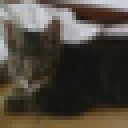

In [13]:
ind = 10
s = StackedView(transpose(train_x[:,:,1,ind]),transpose(train_x[:,:,2,ind]),transpose(train_x[:,:,3,ind]));
sc = colorview(RGB, s)

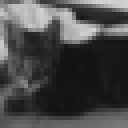

In [14]:
temp = Images.Gray.(sc)

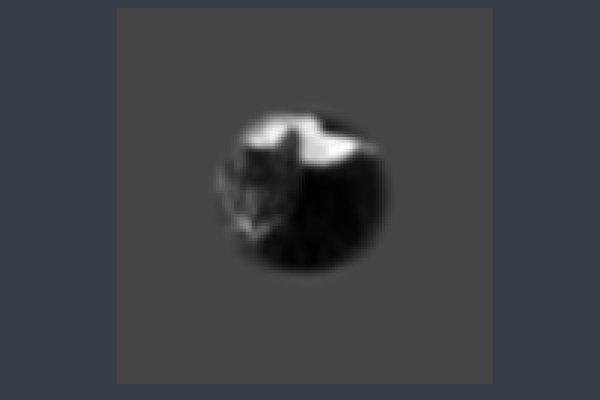

In [15]:
Plots.heatmap(
    cifar_pad(lst_train[10]),
    xlims=(1,128),
    ylims=(1,128),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:greys,
    #yflip=true,
    legend = :none,
    margin=0mm)

In [16]:
test_image_cat = cifar_pad(lst_train[10]);

In [17]:
ref_WST = cifar_10_trainDHC_sc[:,10];

In [24]:
N = 100
L_test = zeros(N,2)
WST_vec = zeros(1724)
WST_out = zeros(1,1724)
for (indx,i) in enumerate(range(0.01,stop=1,length=N))
    c = i
    A = c.*rand(d,128,128)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_image_cat.+A,filter_hash)
    WST_vec .= StatsBase.transform(dt, WST_vec)
    L_test[indx,2] = norm(WST_vec.-ref_WST,Inf)
end

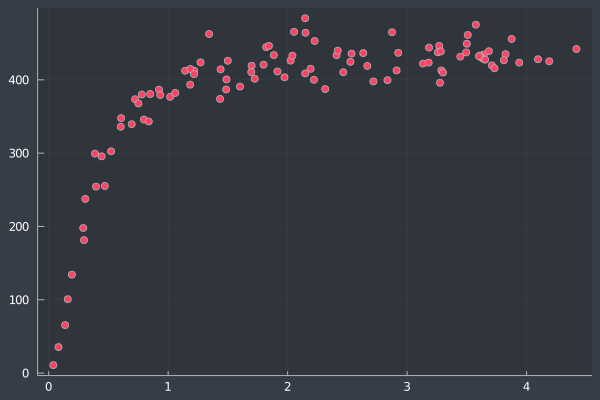

In [26]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

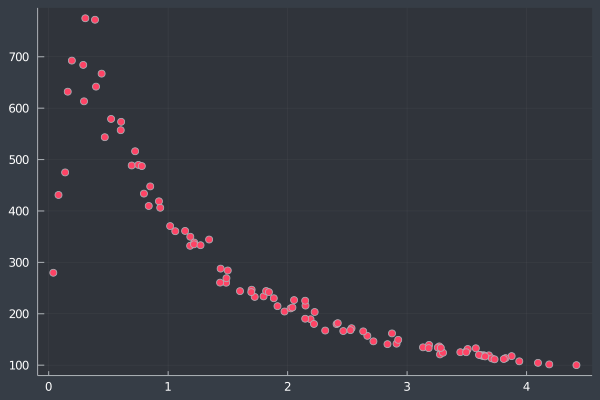

In [27]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2]./L_test[:,1],
    legend = :none,
    margin=0mm)

In [28]:
norm(test_image_cat,Inf)

0.8026960784313726

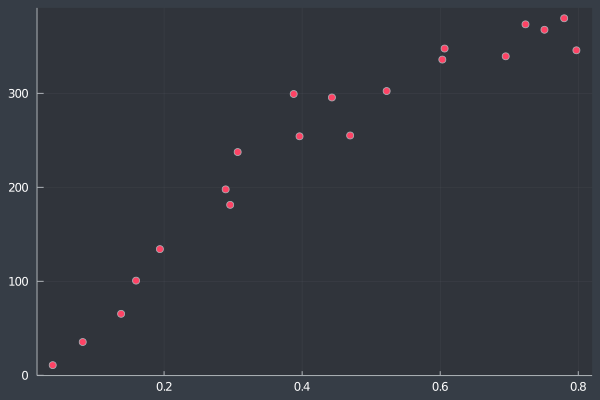

In [29]:
Plots.scatter(
    L_test[1:20,1],
    L_test[1:20,2],
    legend = :none,
    margin=0mm)

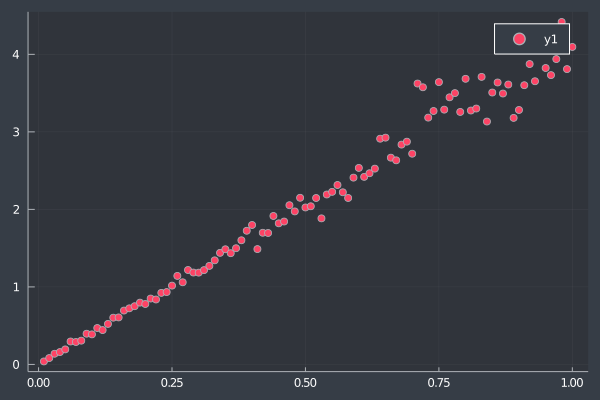

In [30]:
Plots.scatter(range(0.01,stop=1,length=N),L_test[:,1])

In [195]:
N = 100
L_test = zeros(N,2)
WST_vec = zeros(1724)
WST_out = zeros(1,1724)
for (indx,i) in enumerate(range(0.01,stop=0.3,length=N))
    c = i
    A = c.*rand(d,128,128)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_image_cat.+A,filter_hash)
    WST_out .= StatsBase.transform(dt, reshape(WST_vec,1,1724))
    L_test[indx,2] = norm(WST_out.-ref_WST,Inf)
end

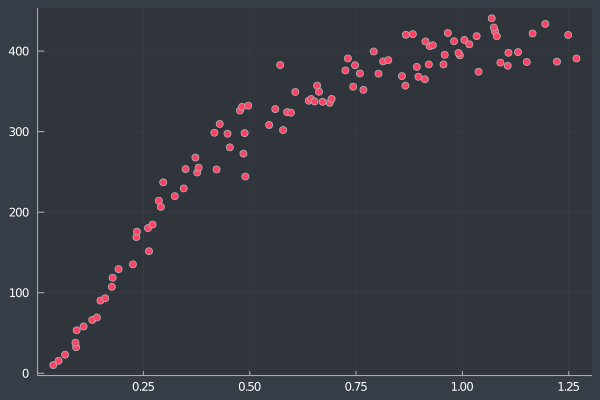

In [196]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

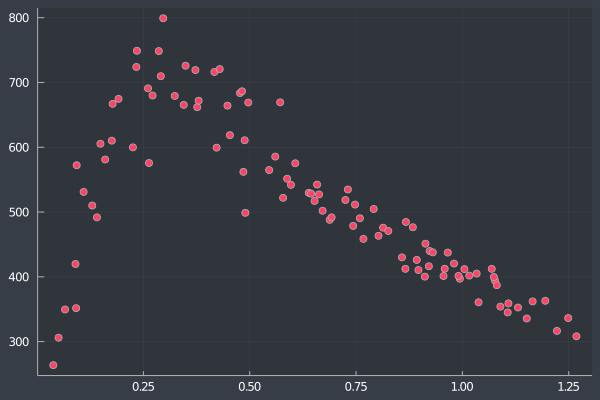

In [197]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2]./L_test[:,1],
    legend = :none,
    margin=0mm)

In [91]:
N = 100
L_test = zeros(N,2)
WST_vec = zeros(1724)
WST_out = zeros(1,1724)
for (indx,i) in enumerate(range(0.001,stop=0.005,length=N))
    c = i
    A = c.*rand(d,128,128)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_image_cat.+A,filter_hash)
    WST_vec .= StatsBase.transform(dt, WST_vec)
    L_test[indx,2] = norm(WST_vec.-ref_WST,Inf)
end

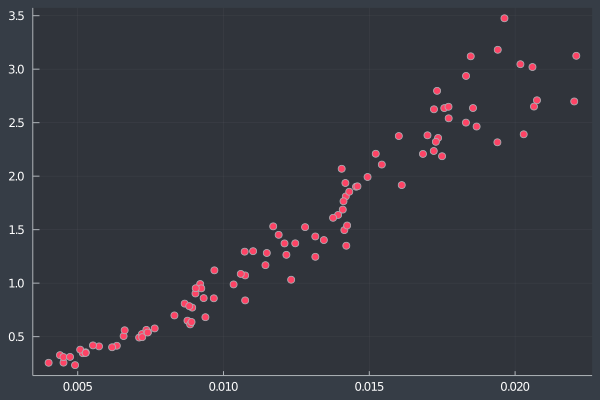

In [92]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

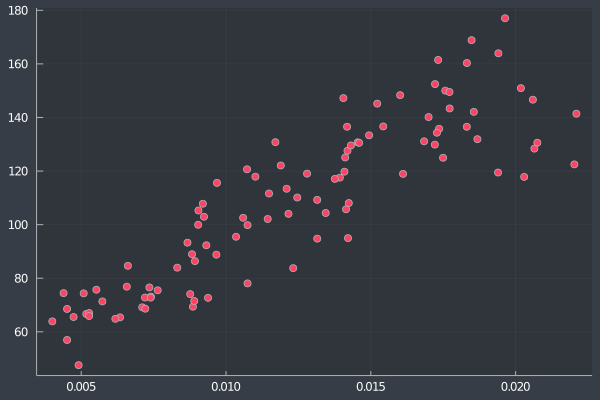

In [93]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2]./L_test[:,1],
    legend = :none,
    margin=0mm)

Let me ask the same question for ISO

In [18]:
cifar_10_trainDHC_iso = isoMaker(transpose(cifar_10_trainDHC),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])

50000×219 Array{Float64,2}:
 0.439929  0.00423718   0.00995869  …  0.00100206   0.0085989   0.0381475
 0.518633  0.00680713   0.0155865      0.0011363    0.0102653   0.0459664
 0.517072  0.0117728    0.00344448     0.00274647   0.0238683   0.111193
 0.340094  0.00279733   0.0102015      0.00139296   0.0122515   0.0547744
 0.395218  0.005993     0.0104313      0.000317038  0.00183677  0.00851301
 0.354879  0.0030018    0.0159912   …  0.00151279   0.0162898   0.0743067
 0.529601  0.00390772   0.0127438      0.00153577   0.0106089   0.0497611
 0.506089  0.00713621   0.0100229      0.000728065  0.00462687  0.0230281
 0.570434  0.00500466   0.00852276     0.000131275  0.00117839  0.00552145
 0.276365  0.00570031   0.00388795     0.00247089   0.022049    0.0992445
 0.308867  0.000422734  0.0340018   …  0.00149572   0.0146727   0.0681638
 0.551511  0.0106842    0.00558509     0.00184353   0.0155659   0.071329
 0.521877  0.00880475   0.00614677     0.0018264    0.0167524   0.0749949
 ⋮        

In [19]:
dt2 = fit(ZScoreTransform, cifar_10_trainDHC_iso, dims=1)

ZScoreTransform{Float64,Array{Float64,1}}(219, 1, [0.4796687881199456, 0.005160200427375496, 0.011371432912905115, 0.10024622160450586, 0.2329741971048979, 0.31725768315981867, 0.2521204317579487, 0.08559256716286087, 1.828804972870332e-5, 4.253585463981179e-6  …  0.05203492743498652, 0.1494114215205845, 0.2572975227516092, 0.2437972393093481, 2.4184593710701978e-6, 1.9399527331660785e-5, 0.0001667887646416227, 0.0017466559609281387, 0.015003899738968691, 0.06865309759435996], [0.12039955472066591, 0.0031507100404821625, 0.00826123951162076, 0.052147620980761346, 0.0829470446155012, 0.07862714664790485, 0.10104774276620426, 0.050637909143025156, 1.2632084009811654e-5, 3.2901050128371443e-6  …  0.02684426815003045, 0.051465490184790144, 0.06390577380112092, 0.09861815645516539, 1.390556139810223e-6, 1.1116471522092391e-5, 9.792842107414218e-5, 0.001017153790698549, 0.008944758156072496, 0.040605979451828686])

In [20]:
cifar_10_trainDHC_iso_sc = StatsBase.transform(dt2, cifar_10_trainDHC_iso)

50000×219 Array{Float64,2}:
 -0.330069  -0.292956   -0.171008   …  -0.732036   -0.716062   -0.751258
  0.323628   0.522718    0.510216      -0.600059   -0.52976    -0.558702
  0.310655   2.09875    -0.959536       0.982954    0.991014    1.04764
 -1.15926   -0.749948   -0.141623      -0.347729   -0.307714   -0.34179
 -0.701419   0.264323   -0.1138        -1.40551    -1.47205    -1.48106
 -1.03646   -0.685053    0.559211   …  -0.229919    0.143765    0.139231
  0.414723  -0.397524    0.166124      -0.207332   -0.491354   -0.465251
  0.219436   0.627162   -0.163232      -1.00141    -1.16012    -1.1236
  0.753869  -0.0493671  -0.344824      -1.58814    -1.54566    -1.55474
 -1.68857    0.171426   -0.905854       0.712018    0.787624    0.753371
 -1.41862   -1.50362     2.73934    …  -0.246708   -0.0370313  -0.0120492
  0.596695   1.75324    -0.700421       0.0952377   0.0628268   0.0659004
  0.350571   1.15674    -0.632431       0.0783998   0.195474    0.15618
  ⋮                         

In [21]:
ref_WST_iso = reshape(cifar_10_trainDHC_iso_sc[10,:],1,219);

In [54]:
isoMaker(reshape(WST_vec,1,1724),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])

1×219 Array{Float64,2}:
 0.276371  0.00581361  0.00883747  …  0.00243634  0.0217107  0.0977945

In [59]:
N = 100
L_test = zeros(N,2)
WST_vec = zeros(1724)
WST_out = zeros(1,219)
for (indx,i) in enumerate(range(0.01,stop=0.3,length=N))
    c = i
    A = c.*rand(d,128,128)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_image_cat.+A,filter_hash)
    WST_out .= isoMaker(reshape(WST_vec,1,1724),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])
    WST_out .= StatsBase.transform(dt2, WST_out)
    L_test[indx,2] = norm(WST_out.-ref_WST_iso,Inf)
end

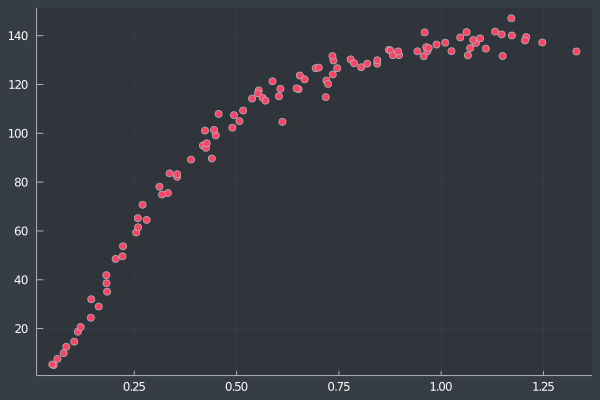

In [60]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

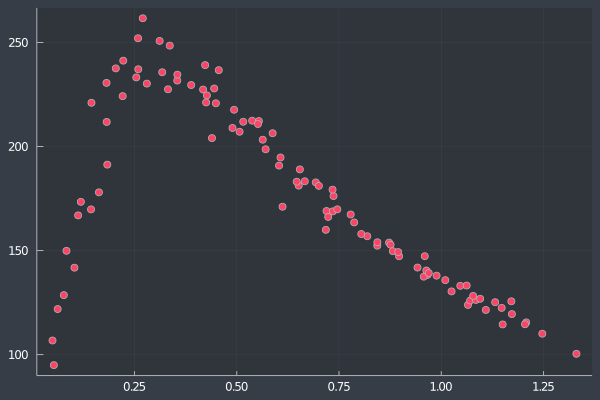

In [61]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2]./L_test[:,1],
    legend = :none,
    margin=0mm)

In [32]:
N = 100
L_test = zeros(N,2)
WST_vec = zeros(1724)
WST_out = zeros(1,219)
for (indx,i) in enumerate(range(0.001,stop=0.01,length=N))
    c = i
    A = c.*rand(d,128,128)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_image_cat.+A,filter_hash)
    WST_out .= isoMaker(reshape(WST_vec,1,1724),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])
    WST_out .= StatsBase.transform(dt2, WST_out)
    L_test[indx,2] = norm(WST_out.-ref_WST_iso,Inf)
end

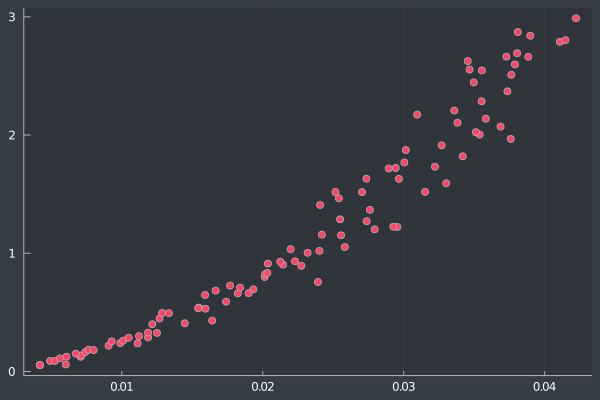

In [86]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

In [87]:
N = 100
L_test = zeros(N,2)
WST_vec = zeros(1724)
WST_out = zeros(1,219)
for (indx,i) in enumerate(range(0.001,stop=0.005,length=N))
    c = i
    A = c.*rand(d,128,128)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_image_cat.+A,filter_hash)
    WST_out .= isoMaker(reshape(WST_vec,1,1724),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])
    WST_out .= StatsBase.transform(dt2, WST_out)
    L_test[indx,2] = norm(WST_out.-ref_WST_iso,Inf)
end

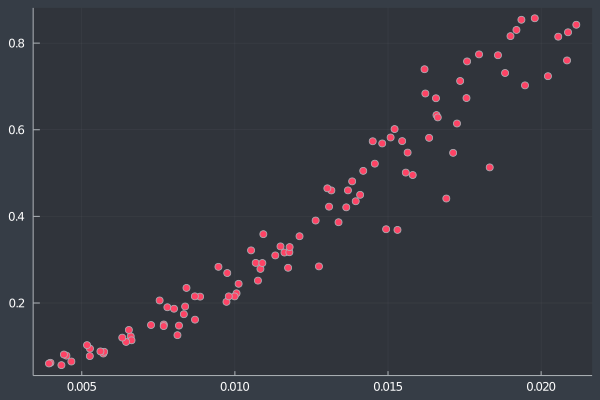

In [88]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

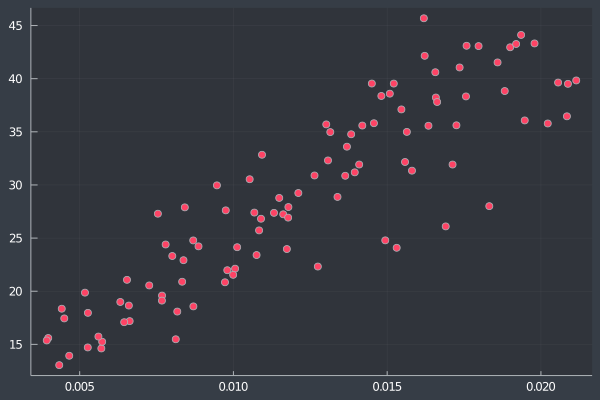

In [89]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2]./L_test[:,1],
    legend = :none,
    margin=0mm)

In [104]:
using Pkg
Pkg.add("GLM")

  Resolving package versions...
  Installed ShiftedArrays ─ v1.0.0
  Installed GLM ─────────── v1.4.0
  Installed StatsModels ─── v0.6.21
Updating `~/.julia/environments/v1.5/Project.toml`
  [38e38edf] + GLM v1.4.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [38e38edf] + GLM v1.4.0
  [1277b4bf] + ShiftedArrays v1.0.0
  [3eaba693] + StatsModels v0.6.21


In [23]:
using GLM, Flux

In [24]:
train_onehot = Flux.onehotbatch(train_y,[0,1,2,3,4,5,6,7,8,9])

10×50000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  1  1  0  0  0  0  0  0  0     0  1  0  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  1  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  1  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  0

In [26]:
cifar_10_trainDHC_iso_sc1 = transpose(cifar_10_trainDHC_iso_sc)

219×50000 Transpose{Float64,Array{Float64,2}}:
 -0.330069     0.323628   0.310655  …  -0.63571    1.51248     0.250266
 -0.292956     0.522718   2.09875       1.07253   -0.419571   -0.080839
 -0.171008     0.510216  -0.959536     -0.686996   0.63478     0.145525
  0.0225507    0.553244  -1.11002      -1.01029    0.293693    0.189562
 -0.393289     0.875128  -0.630094     -0.428971   0.0272793   0.0940383
  1.10772      0.259025  -0.819507  …  -0.385297   0.510716    0.552508
 -0.163095    -0.970951   1.28946       0.935072  -0.654118   -0.551859
 -0.745193    -0.554888   1.03694       0.5917     0.0575746  -0.130578
 -0.176566     1.36075   -1.02681      -0.537412   0.618322    0.236667
 -0.0636124    1.60518   -1.11445      -0.444299   1.61691     0.32478
  0.0785753    0.034064  -0.780461  …   0.203143   2.4506      3.29902
 -0.649769    -0.231818  -0.315672     -0.195767  -0.711861   -0.328101
 -0.466151    -0.291851   0.143301      4.7965    -0.273548   -0.503611
  ⋮               

In [34]:
#x_reg = vcat(cifar_10_trainDHC_iso_sc1,ones(1,50000));
x_reg = cifar_10_trainDHC_iso_sc1

219×50000 Transpose{Float64,Array{Float64,2}}:
 -0.330069     0.323628   0.310655  …  -0.63571    1.51248     0.250266
 -0.292956     0.522718   2.09875       1.07253   -0.419571   -0.080839
 -0.171008     0.510216  -0.959536     -0.686996   0.63478     0.145525
  0.0225507    0.553244  -1.11002      -1.01029    0.293693    0.189562
 -0.393289     0.875128  -0.630094     -0.428971   0.0272793   0.0940383
  1.10772      0.259025  -0.819507  …  -0.385297   0.510716    0.552508
 -0.163095    -0.970951   1.28946       0.935072  -0.654118   -0.551859
 -0.745193    -0.554888   1.03694       0.5917     0.0575746  -0.130578
 -0.176566     1.36075   -1.02681      -0.537412   0.618322    0.236667
 -0.0636124    1.60518   -1.11445      -0.444299   1.61691     0.32478
  0.0785753    0.034064  -0.780461  …   0.203143   2.4506      3.29902
 -0.649769    -0.231818  -0.315672     -0.195767  -0.711861   -0.328101
 -0.466151    -0.291851   0.143301      4.7965    -0.273548   -0.503611
  ⋮               

In [35]:
beta = x_reg*x_reg'

219×219 Array{Float64,2}:
 49999.0       9847.85   -5466.2   …    3678.02    4545.63    4533.78
  9847.85     49999.0   -23647.0       16404.9    16450.8    16483.1
 -5466.2     -23647.0    49999.0      -17771.7   -17998.7   -18091.9
 -5439.68    -25147.2    42036.9      -23381.7   -23674.3   -23811.6
 -3961.89    -20137.0    23410.2      -29493.1   -29860.8   -30023.6
  -193.273     3028.34  -12368.9   …  -26104.6   -27192.8   -27374.2
  4406.98     20892.8   -26459.0       33719.7    34391.9    34716.3
  4521.35     16489.3   -18083.3       48649.1    49939.0    49997.1
 -5026.55    -23005.9    45687.3      -19156.8   -19113.5   -19216.7
 -6166.59    -20085.4    40710.8      -16577.4   -16819.5   -16886.4
 -3285.03     -9296.29   16169.2   …  -12589.2   -12748.0   -12739.9
   300.975     2284.22   -1832.37       7964.76    8154.7     8219.56
   344.549    -1174.85   -1334.28     -12517.4    -9107.61   -9205.3
     ⋮                             ⋱                        
  1832.94     

In [36]:
x_reg*train_onehot'

219×10 Array{Float64,2}:
  2970.71      -964.525      92.8788  …   -134.482    1628.46     176.439
   -37.9936    1825.3     -1940.57         867.593     543.599   2171.11
    -0.671744   217.925     215.791       -398.595   -1151.84     128.561
   428.986      531.219     151.761         87.0223  -1332.18     -66.2784
   644.842      305.287     628.223        800.577   -1601.55    -431.314
   105.972      -78.8617   1487.24    …   1178.77     -694.075  -1279.43
  -363.421     -442.807    -970.642      -1144.76     2195.25     595.523
  -938.432      -78.3872  -1594.13        -879.94      886.262   1551.39
   145.088      392.131    -262.596       -113.161    -519.896    438.6
  -846.406      470.064    -362.427       -692.017    -822.723    494.694
 -1165.13      1196.36     -518.474   …    652.549    -928.03     697.762
  -549.079      207.461    -644.745       -455.841     257.528    475.515
  -246.931      551.686     -25.4545       -94.443     735.23      77.9739
     ⋮          

In [37]:
beta = x_reg*x_reg'\x_reg*train_onehot'

219×10 Array{Float64,2}:
      0.0452317       -0.0256963  …        0.0192634      -0.00409961
      0.00693415       0.0437439          -0.0202344       0.0516313
    -63.7425        -166.829            -231.083        -548.389
   1017.56           579.974               5.45994     -1745.7
   1382.66           752.83            -4199.82         2804.56
  23117.9         -24273.7        …    14984.7        -11797.9
      1.8316e5    -90355.9                 1.4096e5   -25393.7
  28735.4          32448.4             61806.6         37014.3
     -1.06613e5    52169.9            -83360.6         16798.7
     -2.36422e5        1.15472e5          -1.75204e5   28305.5
  59933.2         -23497.7        …    50599.4         -6402.62
      1.2939e5    -60455.2             98996.7         -9987.26
  77364.7         -37225.8             55744.7         -8125.49
      ⋮                           ⋱                   
 -23512.0           8844.5            -19551.2          1255.53
     29.5977      

In [52]:
beta = transpose(train_onehot)\transpose(x_reg)

10×219 Array{Float64,2}:
  0.594142   -0.00759873  -0.000134349  …  -0.237038   -0.180675   -0.187742
 -0.192905    0.365061     0.0435849       -0.0264652  -0.0211874  -0.0141407
  0.0185758  -0.388114     0.0431581       -0.289897   -0.313708   -0.320413
 -0.138615    0.0879414   -0.31764          0.261173    0.210478    0.211428
 -0.192764   -0.536377     0.191431        -0.249349   -0.237777   -0.236567
 -0.0656526   0.183382    -0.448145     …   0.182098    0.148073    0.144937
 -0.356864   -0.420755     0.77212          0.14713     0.0922016   0.0866271
 -0.0268963   0.173519    -0.079719        -0.165831   -0.171647   -0.177048
  0.325692    0.10872     -0.230368         0.0810624   0.174482    0.180253
  0.0352878   0.434222     0.0257122        0.297117    0.299761    0.312665

In [38]:
WST_vec .= DHC_compute(test_image_cat,filter_hash)
WST_out .= isoMaker(reshape(WST_vec,1,1724),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])
WST_out .= StatsBase.transform(dt2, WST_out)

1×219 Array{Float64,2}:
 -1.68857  0.171426  -0.905854  -0.909567  …  0.712018  0.787624  0.753371

In [54]:
temp = WST_out*beta'

1×10 Array{Float64,2}:
 -4.39741  -6.90148  -7.04526  25.9453  …  -0.552733  22.309  2.32551

In [55]:
transpose(temp)

10×1 Transpose{Float64,Array{Float64,2}}:
  -4.3974109877058325
  -6.9014830673657155
  -7.045259100579995
  25.945264314906293
 -15.576243188949727
  25.35769331617363
 -41.464379171555834
  -0.5527328164352443
  22.309037161232716
   2.325513540279767

In [56]:
temp = cifar_10_trainDHC_iso_sc*beta'

50000×10 Array{Float64,2}:
   4.65379     0.217107    7.51344   …    1.1032     -2.49564   -8.42556
   1.71652     4.17762     5.19762        6.58365   -24.3475    -0.794226
  -6.51151    -6.30521   -14.0906        -5.98596    40.277      7.28296
   6.84883    -4.12568    10.9397         1.1589     -3.88328  -10.7695
  16.9817      4.0746     15.0134         3.12248    -8.68097  -11.6888
  -1.95179     5.20139    -5.57801   …   -7.23631   -11.5679     4.10944
 -10.089      -0.404033   -5.35083        4.2218    -12.7014     4.14885
  -1.2721      1.05636    10.2383        22.6326    -21.7713    -4.30611
  15.4634      0.84835    16.851         13.8078    -18.5706   -12.4947
  -4.39741    -6.90148    -7.04526       -0.552733   22.309      2.32551
 -13.9224      8.36548    -0.484849  …  -10.8138    -40.7226    10.1026
  -6.3667     -3.45945    -9.47758       -4.0617     27.3842     2.58186
 -12.4207     -4.28997   -10.603          1.58632    19.5879     6.18225
   ⋮                       

In [60]:
pred_class = mapslices(argmax,temp,dims=2)

50000×1 Array{Int64,2}:
 3
 7
 9
 3
 1
 7
 7
 8
 3
 4
 7
 9
 4
 ⋮
 7
 6
 9
 9
 9
 4
 3
 9
 9
 9
 7
 8

In [61]:
train_y

50000-element Array{Int64,1}:
 6
 9
 9
 4
 1
 1
 2
 7
 8
 3
 4
 7
 7
 ⋮
 5
 1
 4
 2
 0
 1
 0
 2
 6
 9
 1
 1

Hmmm, our CIFAR classification is so bad, I really should have done all of this with MNIST

In [62]:
function mnist_pad(im; θ=0.0)
    impad = zeros(Float64,128,128)
    impad[78:-1:51,51:78] = im'
    imbig = imresize(impad,(256,256))
    if θ != 0.0
        imrot = imrotate(imbig, θ, axes(imbig), Cubic(Throw(OnGrid())))
        imrot[findall(imrot .!= imrot)] .= 0.0
        return imrot
    end
    return imbig
end

function mnist_DHC(params)
    θ, x = params
    image    = mnist_pad(x[:,:], θ=θ)
    WST = DHC_compute(image, filter_hash)
    return WST
end

mnist_DHC (generic function with 1 method)

In [81]:
filter_hash = fink_filter_hash(1,8,nx=256,wd=2)

Dict{String,Any} with 13 entries:
  "j_value"     => [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
  "S2_iso_mat"  => …
  "psi_index"   => Int32[1 7 … 37 43; 2 8 … 38 44; … ; 5 11 … 41 47; 6 12 … 42 …
  "phi_index"   => 49
  "wd"          => [2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
  "pc"          => 1
  "npix"        => 256
  "S1_iso_mat"  => …
  "theta_value" => [0.0, 0.392699, 0.785398, 1.1781, 1.5708, 1.9635, 2.35619, 2…
  "J_L"         => Int32[0 0; 1 0; … ; 5 7; 6 0]
  "fs_center_r" => [64.0, 32.0, 16.0, 8.0, 4.0, 2.0]
  "filt_value"  => [[0.00339714, 0.00366446, 0.00366446, 0.00339714, 0.00024277…
  "filt_index"  => Array{CartesianIndex{2},1}[[CartesianIndex(23, 25), Cartesia…

In [82]:
mnist_trainDHC = h5read("../scratch_AKS/data/mnist_DHC_out.h5", "main/data")

2452×60000 Array{Float64,2}:
 0.00658821   0.0074427    0.00465375   …  0.00488951   0.00500728
 0.00467028   0.00532728   0.0028209       0.00279794   0.00300195
 0.000501216  0.000937274  0.0024097       0.00126016   0.00156364
 0.00590518   0.0181909    0.0460029       0.0129069    0.0199042
 0.00732154   0.0318051    0.0807967       0.0233499    0.0226533
 0.0226797    0.0207401    0.0552776    …  0.0131304    0.0242825
 0.0372044    0.0287135    0.0117534       0.0269316    0.026275
 0.017223     0.0176758    0.0103635       0.0150283    0.0142951
 0.00063867   0.000724613  0.0011316       0.000661802  0.00102876
 0.0101342    0.0127489    0.0189673       0.00619842   0.0155152
 0.019228     0.0269673    0.0386437    …  0.0135321    0.0120352
 0.0204123    0.0252       0.0301532       0.00769467   0.01161
 0.0264403    0.0186834    0.0138496       0.0194552    0.0137061
 ⋮                                      ⋱               
 0.0027207    0.0037309    0.00240802   …  0.00817015  

In [83]:
mnist_trainDHC_iso = isoMaker(transpose(mnist_trainDHC),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])

60000×310 Array{Float64,2}:
 0.00658821  0.00467028  0.00634238  …  0.00102831   0.00905101  0.0405303
 0.0074427   0.00532728  0.00586253     0.00115699   0.0101763   0.0455576
 0.00465375  0.0028209   0.0125487      0.000846373  0.00745374  0.0333812
 0.00410132  0.00303254  0.00482105     0.000632042  0.00554638  0.0248026
 0.00555635  0.00385561  0.00802295     0.000920586  0.00808962  0.036136
 0.0070851   0.0049155   0.00638338  …  0.00116182   0.01021     0.045638
 0.00422363  0.0032602   0.00577316     0.000632955  0.00556096  0.0248341
 0.00858489  0.00651869  0.00439048     0.00126245   0.011102    0.0496914
 0.00260273  0.00174105  0.00879425     0.000452896  0.00397799  0.0177571
 0.0052428   0.00355363  0.00832996     0.000887853  0.00779463  0.0348279
 0.00683307  0.00527448  0.00397807  …  0.00100732   0.0088575   0.0395943
 0.00341079  0.0021406   0.0147536      0.000615684  0.00540028  0.0241609
 0.00855952  0.00638279  0.00389686     0.00126905   0.0111682   0.0500118

In [84]:
sc1 = fit(ZScoreTransform, mnist_trainDHC, dims=1)
sc2 = fit(ZScoreTransform, mnist_trainDHC_iso, dims=1)

ZScoreTransform{Float64,Array{Float64,1}}(310, 1, [0.006252307946697562, 0.004516578273261945, 0.007879792776455754, 0.11714615929938106, 0.27260915065938823, 0.21089238300850824, 0.22005393379483323, 0.12278347813541175, 0.04850573285936983, 4.74909908600921e-6  …  0.08508261368047815, 0.15246865999384687, 0.11709911648939705, 1.6830009825364468e-7, 1.3353239261324924e-6, 1.0756182526553828e-5, 9.720653263940019e-5, 0.000985407235415487, 0.008663731771534728, 0.03874710624321377], [0.00207191785271724, 0.0018150651263138704, 0.00513003039114771, 0.046158807425551646, 0.04952346901102509, 0.049518612329569216, 0.045953858156062614, 0.029345506339564086, 0.012732224365625294, 2.997656430726233e-6  …  0.01565162002013992, 0.03108841395624623, 0.028046543180337818, 4.4080273785625076e-8, 3.493113993398499e-7, 2.8131533953139854e-6, 2.5427311152021214e-5, 0.0002578711580704246, 0.002270817058135744, 0.010174913385567027])

In [85]:
mnist_trainDHC_sc = StatsBase.transform(sc1, mnist_trainDHC)
mnist_trainDHC_iso_sc = StatsBase.transform(sc2, mnist_trainDHC_iso)

60000×310 Array{Float64,2}:
  0.16212     0.0846827  -0.299689   …   0.166385    0.170548    0.175253
  0.574536    0.446652   -0.393227       0.665399    0.666073    0.669343
 -0.771535   -0.934225    0.910113      -0.53916    -0.532843   -0.527363
 -1.03816    -0.81762    -0.596243      -1.37032    -1.37279    -1.37048
 -0.335899   -0.364155    0.0279059     -0.251371   -0.252821   -0.256619
  0.401945    0.219782   -0.291697   …   0.684111    0.680952    0.67724
 -0.979129   -0.692195   -0.410648      -1.36678    -1.36637    -1.36738
  1.12581     1.10305    -0.680175       1.07436     1.07374     1.07562
 -1.76145    -1.52916     0.178255      -2.06503    -2.06346    -2.06291
 -0.487233   -0.530534    0.0877519     -0.378306   -0.382725   -0.385183
  0.280299    0.417562   -0.760565   …   0.0849578   0.0853303   0.0832677
 -1.37144    -1.30903     1.33991       -1.43375    -1.43712    -1.43355
  1.11356     1.02818    -0.776395       1.09995     1.1029      1.1071
  ⋮              

In [86]:
train_x, train_y = MNIST.traindata()
test_x, test_y   = MNIST.testdata()

lst_train = Array{Any}(undef, 0)
for i = 1:60000
    push!(lst_train,train_x[:,:,i])
end

lst_test = Array{Any}(undef, 0)
for i = 1:10000
    push!(lst_test,test_x[:,:,i])
end

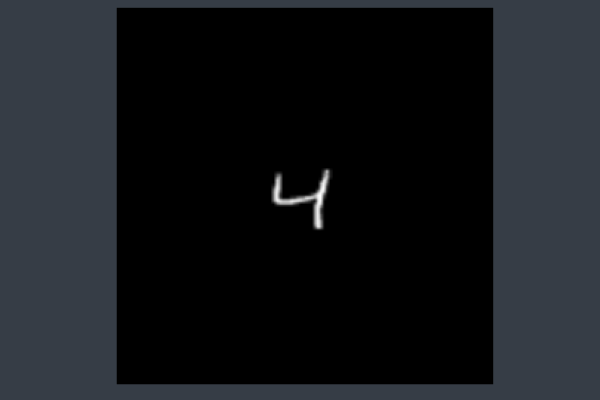

In [87]:
Plots.heatmap(
    mnist_pad(lst_train[3]),
    xlims=(1,256),
    ylims=(1,256),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:greys,
    #yflip=true,
    legend = :none,
    margin=0mm)

In [91]:
ref_WST_iso = reshape(mnist_trainDHC_iso_sc[3,:],1,310);
test_four = mnist_pad(lst_train[3]);

In [92]:
N = 100
L_test = zeros(N,2)
WST_vec = zeros(2452)
WST_out = zeros(1,310)
for (indx,i) in enumerate(range(0.001,stop=0.005,length=N))
    c = i
    A = c.*rand(d,256,256)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_four.+A,filter_hash)
    WST_out .= isoMaker(reshape(WST_vec,1,2452),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])
    WST_out .= StatsBase.transform(sc2, WST_out)
    L_test[indx,2] = norm(WST_out.-ref_WST_iso,Inf)
end

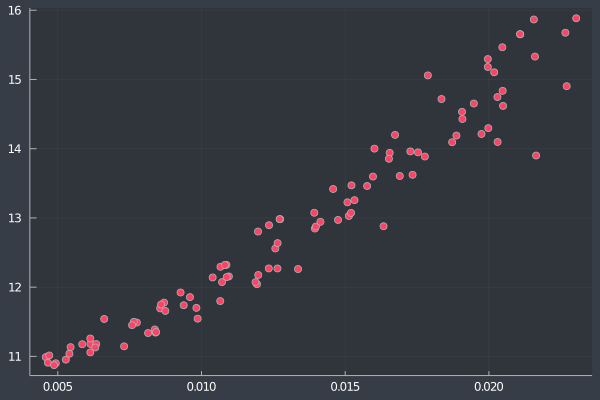

In [94]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

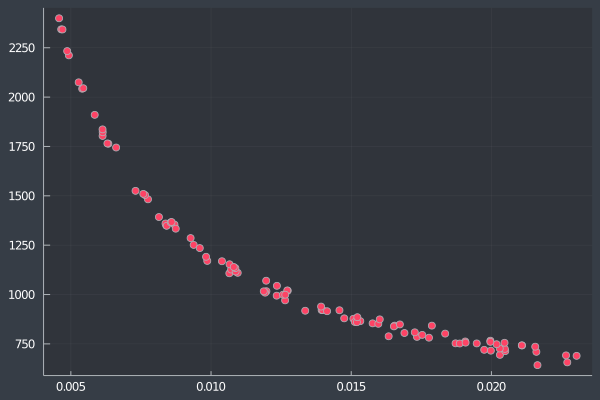

In [95]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2]./L_test[:,1],
    legend = :none,
    margin=0mm)

In [96]:
norm(test_four,Inf)

0.9870098039215687

In [99]:
N = 20
L_test = zeros(N,2)
WST_vec = zeros(2452)
WST_out = zeros(1,310)
for (indx,i) in enumerate(range(0.001,stop=0.2,length=N))
    c = i
    A = c.*rand(d,256,256)
    L_test[indx,1] = norm(A,Inf)
    WST_vec .= DHC_compute(test_four.+A,filter_hash)
    WST_out .= isoMaker(reshape(WST_vec,1,2452),filter_hash["S1_iso_mat"],filter_hash["S2_iso_mat"])
    WST_out .= StatsBase.transform(sc2, WST_out)
    L_test[indx,2] = norm(WST_out.-ref_WST_iso,Inf)
end

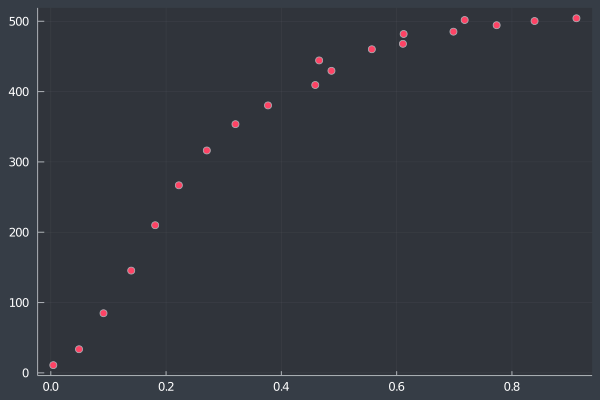

In [100]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2],
    legend = :none,
    margin=0mm)

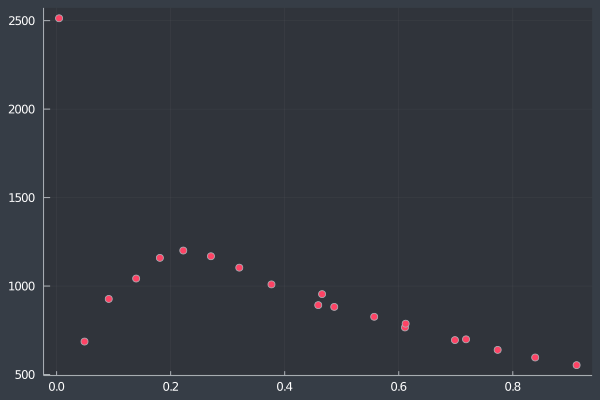

In [101]:
Plots.scatter(
    L_test[:,1],
    L_test[:,2]./L_test[:,1],
    legend = :none,
    margin=0mm)

In [102]:
using Pkg
Pkg.add("PyCall")

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
